# HHT実装テスト

In [2]:
#import
import scipy as scp
import numpy as np
from scipy import signal,interpolate
import pylab
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_max_min_ids(y):## 極大極小index抽出関数
    maxId = signal.argrelmax(y)
    minId = signal.argrelmin(y)
    return maxId[0], minId[0]

def get_max_min_spline(y,t,spl=3):##3rd order-splinefunction
    maxId , minId = get_max_min_ids(y)
    f_max = InterpolatedUnivariateSpline(t[maxId],y[maxId],k=spl)
    f_min = InterpolatedUnivariateSpline(t[minId],y[minId],k=spl)
    return f_max, f_min

def get_protIMF(y,t):##prototype IMF
    U, L = get_max_min_spline(y,t)
    mean = (U(t)+L(t))/2.
    protIMF = y - mean
    return protIMF, mean

def stoppage_criterion_zerocross(sig):## zerocross criterion
    #sigがIMFかどうかを判断する。
    con = False
    #print len(sig)
    maxima, minima = get_max_min_ids(sig)
    chk = [i for i in range(len(sig)-1) if (sig[i]>=0 and sig[i+1]<=0) or (sig[i]<=0 and sig[i+1]>=0)]
    #print len(chk)
    #print len(maxima)+len(minima)
    if (np.abs(len(chk)-(len(maxima)+len(minima))) <= 1):
        con = True
    return con

def stoppage_criterion_cauchy(sig,t,thr=1.0e-5):## cauchy criterion
    #sigがIMFかどうかを判断する。
    ##入力した信号の任意の点に対して、極大値をつないだエンベロープと極小値を繋いだエンベロープの平均が0であること。
    ##理想的0の近似値として、入力した信号のMaxMinエンベロープの平均が、入力した信号に対して十分小さいこと。Cauchy条件
    f_max, f_min = get_max_min_spline(sig,t)
    mean = (f_max(t)+f_min(t))/2.
    h = sig-mean
    cauchy = False
    #print (np.sum(np.abs(mean))/np.sum(np.abs(protIMF)))
    if np.sum(mean**2)/np.sum(h**2) < thr:
        cauchy = True
    return cauchy

def S_stoppage_criterion(i,S=5):## How many times is zerocross criterion called.
    crite = False
    if i==S:
        crite =True
    return crite

def maxmin_condition(y,thr=3):
    maxID,minID=get_max_min_ids(y)
    if len(maxID) < thr or len(minID) < thr:
        return False
    else:
        return True
    
def EMD(y,t,maxminN=3,spl=3):
    IMFs = []
    r = []
    c = y.copy()
    c0 = y.copy()
    for i in range(20):
        Sstopage=0
        if not maxmin_condition(y=c,thr=maxminN):
            break
        for k in range(20):
            max_sp, min_sp = get_max_min_spline(y=c,t=t,spl=spl)
            m = (max_sp(t)+min_sp(t))/2
            h = c-m
#         h[0]=0
#         h[-1]=0
            if (all([stoppage_criterion_zerocross(sig=h),stoppage_criterion_cauchy(t=t,sig=h)]) or S_stoppage_criterion(i=Sstopage)):
                break
            else:
                if stoppage_criterion_zerocross(sig=h):
                    Sstopage+=1
                c = h
        IMFs.append(h)
        c = c0-h
        c0 = c
    r.append(c) #r= y - sum(h)
    return IMFs,r[0]

def HilbertSpectrogram(t,IMF,xlim=None,ylim=None,title=''):
    G = scp.signal.hilbert(IMF)
    a = np.abs(G)
    Th = np.angle(G)
    dt = np.mean(np.gradient(t))
    f = np.gradient(Th)/dt/(2*np.pi)
    f[f<0] = -1
#    
    plt.figure()
    plt.scatter(t,f,c=a,alpha=0.5,edgecolors=None,linewidth='0')
    plt.colorbar()
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    return {'f':f,'Th':Th,'dt':dt,'Amp':a,'Hilbert':G}

def HilbertSpectrograms(t,IMFs,xlim=None,ylim=None,title=''):
    Gs = []
    As = []
    Ths = []
    dts = []
    fs = []
    for i in range(len(IMFs)):
        G = scp.signal.hilbert(IMFs[i])
        Th = np.angle(G)
        dt = np.mean(np.gradient(t))
        Gs.append(G)
        As.append(np.abs(G))
        Ths.append(Th)
        dts.append(dt)
        f = np.gradient(Th)/dt/(2*np.pi)
        f[f<0] = -1
        fs.append(f)
        del G,Th,dt,f
    ts = np.tile(t,len(IMFs))    
    Gs = np.array(Gs)
    As = np.array(As)
    Ths = np.array(Ths)
    dts = np.array(dts)
    fs = np.array(fs)
    plt.figure()
    plt.scatter(ts,fs,c=As,alpha=0.5,edgecolors=None,linewidth='0')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title(title)
    plt.show()
    return {'f':fs,'Th':Ths,'dt':dts,'Amp':As,'Hilbert':Gs}

def HilbertSpectrograms_jet(HHT,bins=None):
    plt.figure()
    h = plt.hist2d(np.tile(t,len(IM)),HHT['f'].ravel(),bins=bins,weights=(HHT['Amp'].ravel()/np.linalg.norm(HHT['Amp'].ravel())))
    plt.colorbar()
    plt.show()
    return h

# 変調する信号

変調する信号で試す

\begin{equation}
    y(t) = \left(1+ M_a \sin(2\pi f_a t)\right)\sin(2\pi f_c t + M_fm \sin(2\pi f_f t)) + \sin(2\pi f_d t)
\end{equation}   

振幅の強さ幅$1\pm M_a$が周波数$f_a$で変化し,   
周波数$f_c$が周波数$f_f$で位相を$\pm M_fm$ずらすように変化する信号と   
周波数$2 Hz$の信号との信号をHHTする

In [4]:
#Test
#make test signal
N = 4000

m_a  = 0.8 #Amplitude modulation
f_a  = 2  #Amplitude modulation

f_c  = 50  #Basic freq

m_fm = 1.0   #Frequency modulation
f_f  = 5.0  #Frequency modulation

amp_noiz = 0.5 #
timerange=6 #time range of sample signal
rand = np.random.RandomState(40)

t = np.linspace(0,timerange,N)
y = (1+m_a*np.sin(2*np.pi*f_a*t))*np.sin(2*np.pi*f_c*t+m_fm*np.sin(2*np.pi*f_f*t)) + np.sin(2*2*np.pi*t)#+np.sin(2*np.pi*2*t)+2#+np.random.normal(loc=2,scale=0.1,size=N)

作った波形

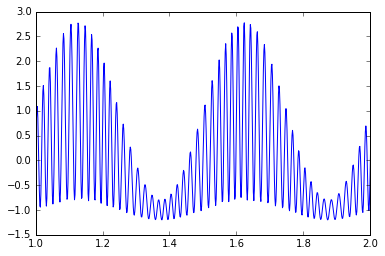

In [5]:
plt.figure()
plt.plot(t,y)
plt.xlim(1,2)
plt.show()

In [6]:
IMFs,r = EMD(t=t,y=y)

EMDした結果からオリジナル信号をリコンストラクトできてるかチェック

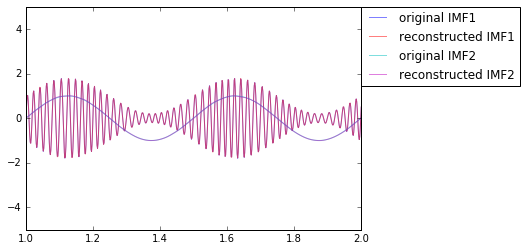

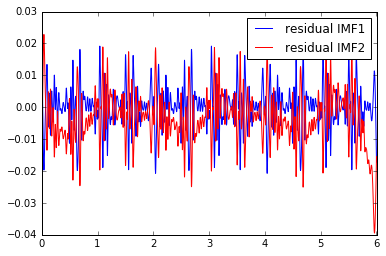

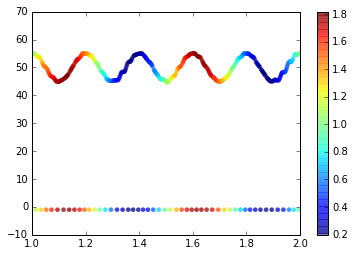

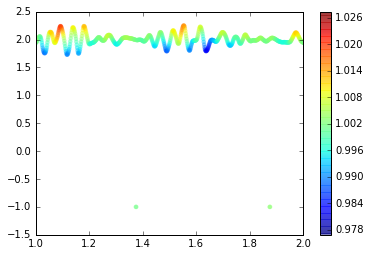

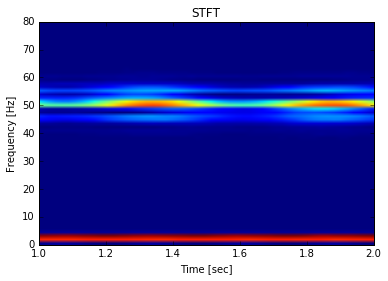

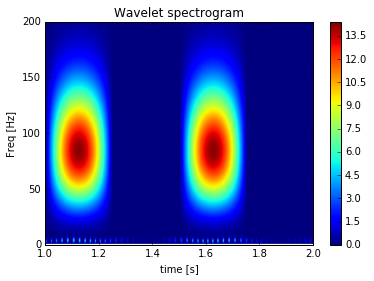

In [8]:
plt.figure()
plt.plot(t,(1+m_a*np.sin(2*np.pi*f_a*t))*np.sin(2*np.pi*f_c*t+m_fm*np.sin(2*np.pi*f_f*t)),'b',alpha=0.5,label='original IMF1')
plt.plot(t,IMFs[0],'r',alpha=0.5,label='reconstructed IMF1')
plt.plot(t, np.sin(2*2*np.pi*t),'c',alpha=0.5,label='original IMF2')
plt.plot(t,IMFs[1],'m',alpha=0.5,label='reconstructed IMF2')
plt.xlim([1,2])
plt.ylim(-5,5)
plt.legend(fontsize=12, bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()
plt.figure()
plt.plot(t,IMFs[0]-(1+m_a*np.sin(2*np.pi*f_a*t))*np.sin(2*np.pi*f_c*t+m_fm*np.sin(2*np.pi*f_f*t)),'b',label='residual IMF1')
plt.plot(t,IMFs[1]- np.sin(2*2*np.pi*t),'r',label='residual IMF2')
plt.legend()
plt.show()
test = HilbertSpectrogram(t,IMFs[0],xlim=[1,2])
dt = test['dt']
HilbertSpectrogram(t,IMFs[1],xlim=[1,2])
#spec_f, spec_t, Sxx = signal.spectrogram(y, 1./dt,nperseg=1024)
plt.figure()
plt.title('STFT')
pxx, freqs, bins, im = pylab.specgram(y ,NFFT = 512, Fs = 1./dt, noverlap =500, window = np.hamming(512), cmap='jet',scale='linear')
#plt.pcolormesh(spec_t, spec_f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,80])
plt.xlim([1,2])
plt.show()

plt.figure()
plt.title('Wavelet')
cwtmatr = signal.cwt(y, signal.ricker, np.arange(1,200))
plt.imshow(cwtmatr, extent=[t.min(), t.max(), 200, 1], cmap='jet', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=0)
plt.ylim([0,200])
plt.xlim([1,2])
plt.title("Wavelet spectrogram")
plt.xlabel("time [s]")
plt.ylabel("Freq [Hz]")
plt.colorbar()
plt.show()


IMFのHilbert変換結果

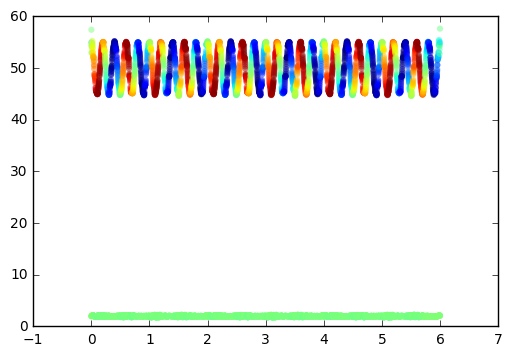

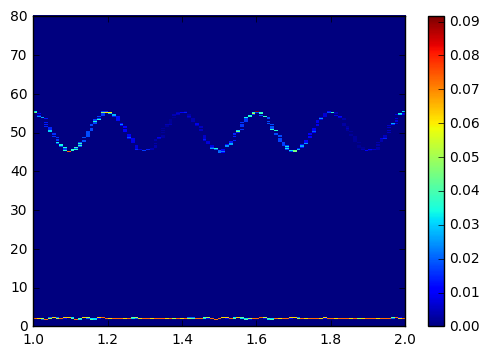

In [186]:
IM = []
IM.append(IMFs[0])
IM.append(IMFs[1])
HHT = HilbertSpectrograms(t,IM,ylim=[0,60])
hist_HHT = HilbertSpectrograms_jet(HHT,bins=[np.linspace(1,2,100),np.linspace(0,80,350)])


# 変調しない二つの信号

In [226]:
#Test
#make test signal
N = 4000
timerange=6
#dt = timerange/float(N)
t = np.linspace(0,timerange,N)
y=np.sin(2*np.pi*10.*t)+np.sin(2*np.pi*1*t)+np.random.normal(loc=0,scale=0.1,size=N)

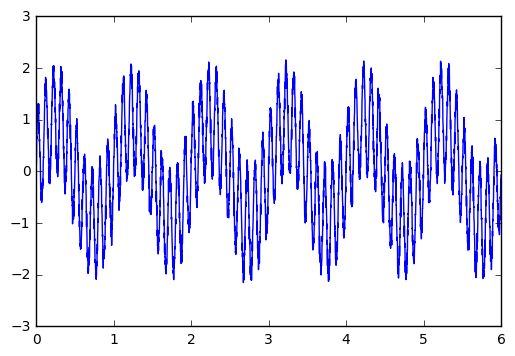

In [227]:
plt.figure()
plt.plot(t,y)
plt.show()

In [228]:
IMFs,r = EMD(t=t,y=y,maxminN=4)

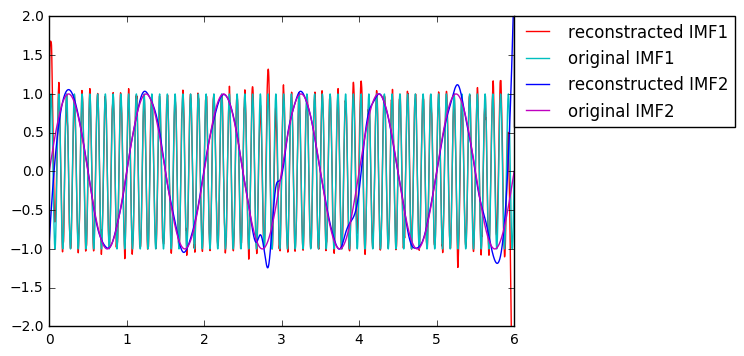

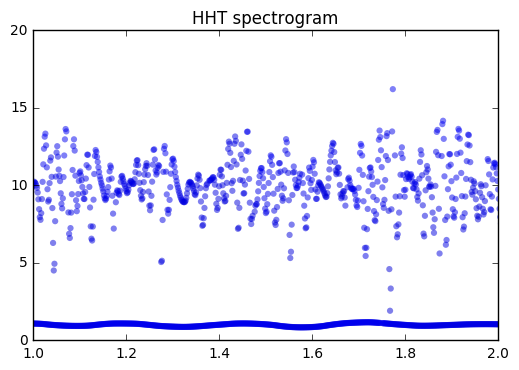

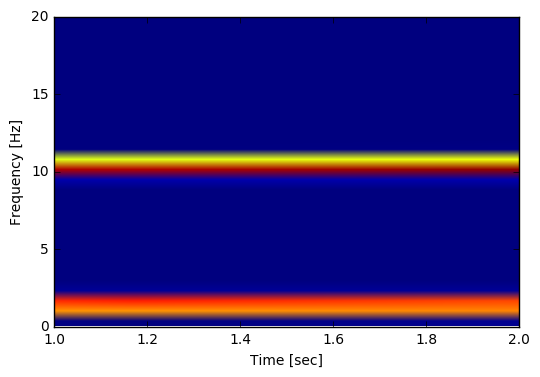

In [240]:
#### plt.figure()
plt.plot(t,IMFs[2]+IMFs[3],'r',label='reconstracted IMF1')
plt.plot(t,np.sin(2*np.pi*10.*t),'c',label='original IMF1')
plt.plot(t,IMFs[4]+r,'b',label='reconstructed IMF2')
plt.plot(t,np.sin(2*np.pi*1*t),'m',label='original IMF2')
plt.legend(fontsize=12, bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.ylim([-2,2])
plt.show()
IM = []
IM.append(IMFs[2]+IMFs[3])
IM.append(IMFs[4]+r)
HilbertSpectrograms(t=t,IMFs=IM,title='HHT spectrogram',ylim=[0,20],xlim=[1,2])

plt.figure()
pxx, freqs, bins, im = pylab.specgram(y ,NFFT = 1024, Fs = 1./dt, noverlap =500, window = np.hamming(1024), cmap='jet',scale='linear')
#plt.pcolormesh(spec_t, spec_f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,20])
plt.xlim([1,2])
plt.show()

plt.show()

# 2つの過渡応答

In [260]:
N = 4000
timerange = 6
lamb = [1,1.5]
f = [4,10]
t = np.linspace(0,6,N)
y = 0
for i in range(2):
    y += np.exp(-lamb[i]*t)*np.sin(2*np.pi*f[i]*t)

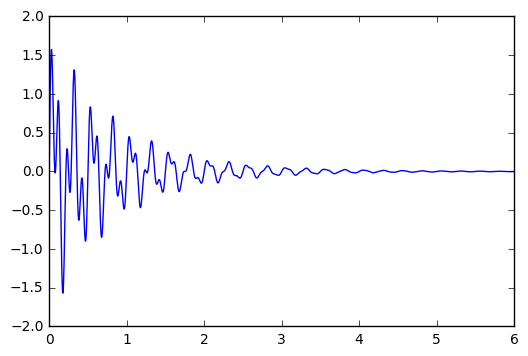

In [261]:
plt.figure()
plt.plot(t,y)
plt.show()

In [262]:
IMFs,r = EMD(t=t,y=y,maxminN=4)

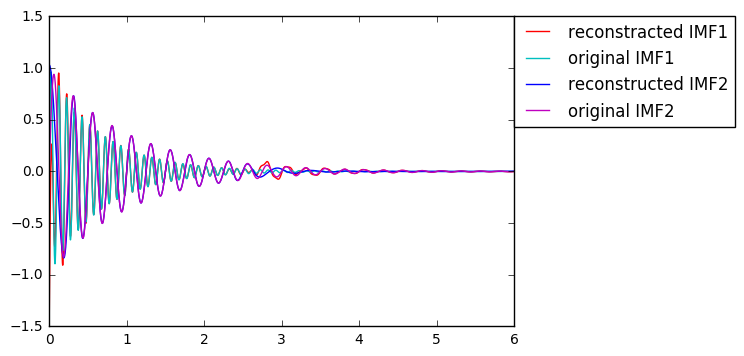

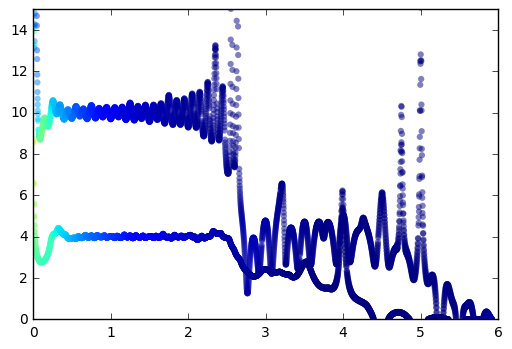

In [275]:
plt.figure()
plt.plot(t,IMFs[0],'r',label='reconstracted IMF1')
plt.plot(t,np.exp(-lamb[1]*t)*np.sin(2*np.pi*f[1]*t),'c',label='original IMF1')
plt.plot(t,IMFs[1],'b',label='reconstructed IMF2')
plt.plot(t,np.exp(-lamb[0]*t)*np.sin(2*np.pi*f[0]*t),'m',label='original IMF2')
plt.legend(fontsize=12, bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()
HHT = HilbertSpectrograms(t=t,IMFs=IMFs[0:2],xlim=[0,6],ylim=[0,15])

過渡応答は、はじめと減衰の尻部分が上手くEMD出来ていないことが原因っぽい